### First Excersie of Langraph tutorial - Creating Veggie Chatbot

---

installing core dependencies

In [1]:
%%capture --no-stderr
%pip install -q langchain_google_genai langchain_core langgraph langchain_community

If you're using google colab so load environment in that way

In [ ]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GEMINI_API_KEY')

if you're working locally so you need to load environment in that way

In [2]:
%%capture --no-stderr
%pip install python-dotenv

create `.env` file in project directory

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()  # Load variables from .env file

os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')

I'm using Gemini Model, so you can use what you like, make sure to install langchain specific package for require Model, and set `API_KEY` accordingly

- Now Initializing Gemini LLM

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temprature=0.4)

I'm using langgraph feature state graph, so for that I'm creating class for my state management

In [6]:
from typing_extensions import TypedDict

class FirstLLMAgentState(TypedDict):
  message: str
  prompt: str
  result: str

This is the first node, where the model is being trained to handle only vegetable- and fruit-related topics. It will provide detailed explanations for these topics based on user input. For any questions outside this domain, it will respond with a predefined message indicating its specialized scope.

In [7]:
def node_init_train(state: FirstLLMAgentState) -> FirstLLMAgentState:
  pre_text_for_prompt = (
      "You are an AI agent with specialized knowledge about fruits and vegetables "
      "When asked about any fruit or vegetable, provide a detailed explanation based on the context provided by the user: {user_context}. "
      "For any questions outside of fruits and vegetables, respond with: 'I don't know about this topic, I'm just a veggie agent.'"
  )
  message = state.get('message')

  return {'message': message, 'prompt': pre_text_for_prompt.format(user_context=message)}

This function invokes the language model (LLM) using the provided prompt from the state and returns the model's response.

In [8]:
def call_llm(state: FirstLLMAgentState) -> FirstLLMAgentState:
  llm_result = llm.invoke(state.get('prompt'))
  return {'result': llm_result.content}

##### State Graph Definition and Compilation

This section defines and compiles a state graph using LangGraph. The graph consists of nodes that handle specific tasks and edges that determine the execution flow.

In [9]:
from langgraph.graph import START, END, StateGraph
from langgraph.graph.state import CompiledStateGraph

builder: StateGraph = StateGraph(state_schema=FirstLLMAgentState)

# adding nodes
builder.add_node('n1', node_init_train)
builder.add_node('n2', call_llm)

# adding edges
builder.add_edge(START, 'n1')
builder.add_edge('n1', 'n2')
builder.add_edge('n2', END)

# making graph
graph: CompiledStateGraph = builder.compile()

##### Displaying the Graph Structure

The following code visualizes the compiled graph using Mermaid PNG

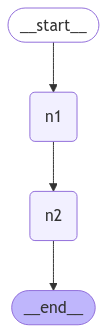

In [10]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

The following code runs the compiled graph with an input message and prints the result:

In [11]:
result: FirstLLMAgentState = graph.invoke({"message": "What's up?"})

print("Question: " + result.get('message'))
print("Answer: " + result.get('result'))

Question: What's up?
Answer: Okay, I'm ready to talk produce!  Ask me anything about fruits and vegetables.

